## 

## Potential für Mögliche Neubauten.

Für unsere Erste "Low Hanging Fruit"-Frage "Mithilfe von Daten aus der Raumplanung, zu vorhandenem Bauland und der Geschossflächenreserve, wird ein Potential für mögliche Neubauten berechnet" fanden wir Daten auf https://geo.lu.ch, die im ersten Augenblick sehr vielversprechend aussahen.

Diese Daten können unter der URL "https://daten.geo.lu.ch/produkt/zonplanx_col_v3" und dem Dropdown-Menü "Grundnutzung" gefunden werden.

> **WICHTIG!** Dieses Notebook beinhaltet den Fehlerhaften Versuch mit den Daten der Raumplanung Rückschlüsse auf mögliche Neubauten zu ziehen. Alle Schritte sind dokumentiert und am Ende ist noch ein Kommentar vorhanden wieso es nicht klappte mit diesen Daten.

> **ACHTUNG!** Das Notebook braucht in etwa 3 Minuten bis es vollständig fertig ist.

In [1]:
# install Libraries
# run this if you do not have all the libraries installed
# -U flag was omitted because it is probably not necessary to upgrade the libraries
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install matplotlib

In [2]:
# import libraries
import geopandas as gpd
import numpy as np

## Laden der Daten

Einlesen der Shape-Dateien des BFS (https://www.bfs.admin.ch/bfs/en/home/statistics/regional-statistics/base-maps/cartographic-bases.html)

In [3]:
municipalities_shapedata = gpd.read_file("./Data/shape/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp")
lu_zone_shapedata = gpd.read_file("./Data/shape/ZPGNDNTZ_V1_PY.shp")

Wir entfernen alle Kollonen, deren Daten wir nicht brauchen werden. Dies vereinfacht die Handhabung der DataFrames.

In [4]:
lu_zone_shapedata = lu_zone_shapedata.drop(set(lu_zone_shapedata.columns) ^ \
 {'BAUWEISE', 'DATEOFDEC', 'DATEOFVALI', 'FAHOE_MAX', 'FAHOE_MIN', 'GEBBREITE', 
 'GEBLAENGE', 'GESCHOSSZA', 'GESHOE_AN', 'GESHOE_MAX', 'GESHOE_MIN', 'GRUENFLZI',
 'LAERMEMPF', 'RECHTSTAT',  'SHAPE_Area', 'SHAPE_Leng', 'TRAUFHOEHE', 'UEZ1_AN', 
 'UEZ1_MAX', 'UEZ1_MIN', 'UEZ2', 'UEZ3', 'UEZ4', 'WOHANT_AN', 'WOHANT_MAX',
 'WOHANT_MIN', 'ZONTYP_BEZ', 'ZONTYP_KT', 'ZONTYP_PBG', 'geometry'}, axis=1).reset_index(drop=True)

municipalities_shapedata = municipalities_shapedata.drop(set(municipalities_shapedata.columns) ^ \
 {'NAME', 'BFS_NUMMER', 'KANTONSNUM', 'GEM_FLAECH', 'BEZIRKSNUM', 'geometry'}, axis=1).reset_index(drop=True)

Bevor wir mit dem Vorbereiten der Daten beginnen, prüfen wir, ob genügend Datensätze in den relevanten Feldern auch Daten aufweisen. HINT: dies gab ein Lessons Learned!

In [5]:
lu_zone_shapedata.value_counts(['WOHANT_AN', 'GEBLAENGE', 'GEBBREITE', 'GESCHOSSZA'])

WOHANT_AN  GEBLAENGE  GEBBREITE  GESCHOSSZA
0.0        0.0        0.0        0             31922
           25.0       0.0        2               747
           0.0        0.0        3               687
1.0        0.0        0.0        0               654
0.0        0.0        0.0        2               422
                                               ...  
           15.0       0.0        1                 1
           30.0       0.0        4                 1
           45.0       0.0        5                 1
           40.0       0.0        5                 1
           37.0       0.0        0                 1
Length: 71, dtype: int64

Insgesamt haben 31920 Datensätze keine Daten über WOHANT_AN, GEBLAENGE, GEBBREITE, GESCHOSSZA. Dies kann sein, da auch Flüsse, Wälder oder Strassen im Datenbestand sind. Um zu prüfen wieviel Wohnzonen im Datensatz sind nehmen wir alle Daten im DataFrame und bilden die Differenz zu diesen 31920 bei denen wir wissen, dass keine Daten drin sind. 

In [6]:

len(lu_zone_shapedata) - 31920 

5611

Der nächste Schritt besteht darin herauszufinden wie viele der einzelnen Einträge (auch Zonen in diesem Fall) Wohnzonen sind. Es sind alle die, bei denen der nächste Query `True` returned.

In [7]:
#1000:	'Wohnzone'
#2000:	'Kern- oder Dorfzone'
#3000:	'Mischzone'
#5900:	'weitere Bauzone'
#6200:	'Reservezone'
lu_zone_shapedata.ZONTYP_PBG.isin([1000, 2000, 3000, 5900, 6200]).value_counts()

False    29722
True      7809
Name: ZONTYP_PBG, dtype: int64

Um Daten übereinander legen zu können muss das `Coordinate Reference System` beider Datensätze übereinstimmen.

In [8]:
municipalities_shapedata.crs

<Compound CRS: COMPD_CS["CH1903+ / LV95 + LN02 height",PROJCS["CH ...>
Name: CH1903+ / LV95 + LN02 height
Axis Info [cartesian|vertical]:
- [east]: Easting (metre)
- [north]: Northing (metre)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich
Sub CRS:
- CH1903+ / LV95
- LN02 height

In [9]:
lu_zone_shapedata.crs

<Derived Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

Wir gleichen `lu_zone_shapedata` an, um auf das gleiche System zu kommen.

In [10]:
lu_zone_shapedata.to_crs(municipalities_shapedata.crs, inplace=True)

`municipalities_shapedata` hat alle gemeinden der Schweiz enthalten. Wir brauchen Gemeinden vom Kanton Luzern.

In [11]:
# Find the right KANTONSNUM
Kantonsnummer=municipalities_shapedata[municipalities_shapedata.NAME.str.contains("Luzern")].KANTONSNUM.values[0]
print("Luzerner Kantonsnummer ist", int(Kantonsnummer))

Luzerner Kantonsnummer ist 3


In [12]:
# Drop entries that are not in the canton of Lucerne
lu_municipalities_shapedata = municipalities_shapedata[municipalities_shapedata.KANTONSNUM == Kantonsnummer].reset_index(drop=True)

Dies können wir nun als Karte plotten

<Axes: >

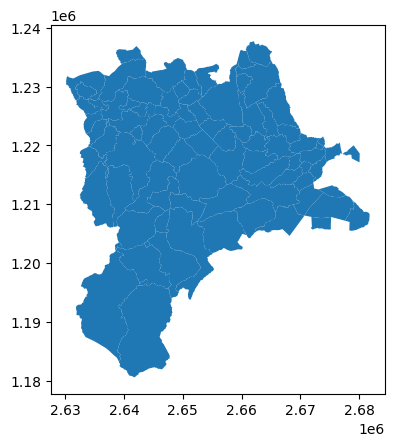

In [13]:
lu_municipalities_shapedata.plot()
#lu_municipalities_shapedata.explore()

Als nächstes müssen die einzelnen Zonen in der jeweiligen Gemeinde zugewiesen werden. Dies ist leider nicht im Datenset mit den Zonendaten enthalten. Um dies zu bewerkstelligen, nutzen wir die GeoPandas-Funktion `intersects`. diese gibt True zurück im Falle mindestens ein Punkt eines Polygons in einer Fläche eines anderen liegt. Wenn eine Überschneidung stattfindet, dann speichern wir die Zone und die Informationen der Gemeinde, in der sich die Zone befindet, in einem Array ab. Anschliessend wird die BFS-Gemeindenummer zurück in das DataFrame gemapped.

In [14]:
mapped_municipalities = []

for zone in lu_zone_shapedata.geometry.items():
    for mun in lu_municipalities_shapedata.iterrows():
        if zone[1].intersects(mun[1].geometry):
            mapped_municipalities.append((zone[0], mun[1].NAME, mun[1].BFS_NUMMER))
            break

In [15]:
lu_zone_shapedata["municipality_bfs_number"] = lu_zone_shapedata.index.map({row[0]: row[2] for row in mapped_municipalities})
lu_zone_shapedata.dropna(subset=['municipality_bfs_number'], inplace=True)
lu_zone_shapedata = lu_zone_shapedata.astype({'municipality_bfs_number': 'int32'})

Um zu sehen, ob dies auch einigermassen stimmt, plotten wir hier Luzern und dann Emmen. Den Grundrissen kann man entnehmen, dass dies funktioniert hat.

<Axes: >

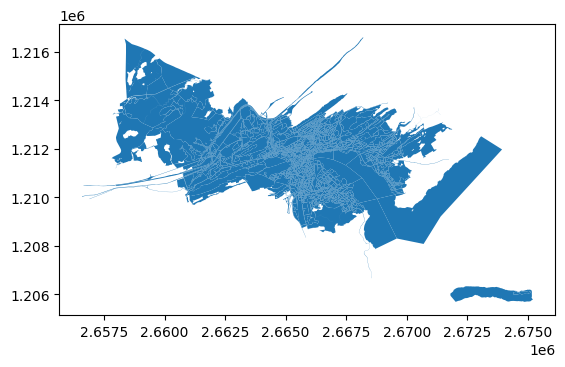

In [16]:
# Plot Luzern
lu_zone_shapedata[lu_zone_shapedata.municipality_bfs_number == 1061].plot()

<Axes: >

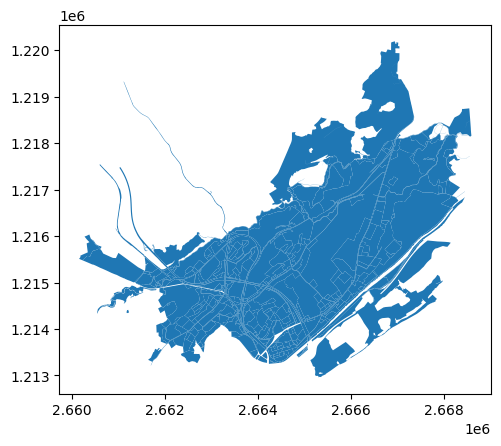

In [17]:
# Plot Emmen
lu_zone_shapedata[lu_zone_shapedata.municipality_bfs_number == 1024].plot()

Nun sind alle Zonen einer bestimmten Gemeinde der entsprechenden Gemeinde zugeordnet. Es müssen nun die relevanten Zonen extrahiert werden. Für das wird ein `dict` mit den entsprechenden Mapping-Daten erstellt und anschliessend werden alle Felder, die nicht einem dieser Werte entsprechen, gedroppt.

In [18]:
pbg_mapping_all = {
    1000:	'Wohnzone',
    2000:	'Kern- oder Dorfzone',
    3000:	'Mischzone',
    4000:	'Arbeitszone',
    5100:	'Zone für öffentliche Zwecke',
    5200:	'Zone für Sport- und Freizeitanlagen',
    5300:	'Grünzone',
    5400:	'Sonderbauzone',
    5500:	'Verkehrszone',
    5900:	'weitere Bauzone',
    6000:	'Landwirtschaftszone',
    6100:	'Freihaltezone',
    6200:	'Reservezone',
    6300:	'Übriges Gebiet A',
    6400:	'Übriges Gebiet C',
    6500:	'Übriges Gebiet D',
    6600:	'Weilerzone',
    6700:	'Deponiezone / Abbauzone',
    6800:	'weitere Nichtbauzone',
    6850:	'Wald',
    6900:	'Naturschutzzone',
    6950:	'weitere Schutzzone'
}
# take the relevant subset of the mapping data
pbg_mapping_inhabit = {
    1000:	'Wohnzone',
    2000:	'Kern- oder Dorfzone',
    3000:	'Mischzone',
    5900:	'weitere Bauzone',
    6200:	'Reservezone',
}

In [19]:
building_zone_living = lu_zone_shapedata[lu_zone_shapedata.ZONTYP_PBG.isin(pbg_mapping_inhabit.keys())].reset_index(drop=True)

Nun sind nur noch Bauzonen im Dataset enthalten.

<Axes: >

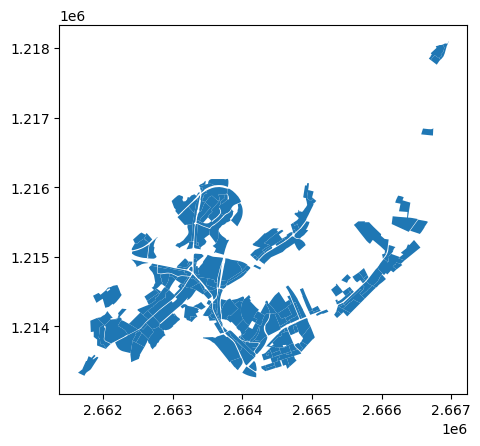

In [20]:
building_zone_living[building_zone_living.municipality_bfs_number == 1024].plot()

Der nächste Schritt ist die Grundfläche und den Überbauungsgrad aus dem DataFrame zu ziehen und Berechnungen anzustellen. Für die Genauere Analysierung dieser Daten wurde das `reduced_for_math` DataFrame erstellt. Als wir dann `value_counts()` darauf aufgerufen hatten, sahen wir das die meisten Werte eigentlich Null-Werte sind. Wir hätten hier genauer hinsehen sollen und das mapping erst dann machen, als wir wussten, dass Brauchbare Daten im DataFrame sind. Schade - haben fürs Mapping einige Zeit verloren...

In [21]:
building_zone_living[building_zone_living.municipality_bfs_number == 1024].columns



Index(['ZONTYP_PBG', 'ZONTYP_KT', 'ZONTYP_BEZ', 'RECHTSTAT', 'DATEOFDEC',
       'DATEOFVALI', 'UEZ1_MAX', 'UEZ1_MIN', 'UEZ2', 'UEZ3', 'UEZ4',
       'GRUENFLZI', 'GESHOE_MAX', 'GESHOE_MIN', 'FAHOE_MAX', 'FAHOE_MIN',
       'TRAUFHOEHE', 'GEBLAENGE', 'GEBBREITE', 'WOHANT_MAX', 'WOHANT_MIN',
       'BAUWEISE', 'LAERMEMPF', 'GESCHOSSZA', 'UEZ1_AN', 'GESHOE_AN',
       'WOHANT_AN', 'SHAPE_Leng', 'SHAPE_Area', 'geometry',
       'municipality_bfs_number'],
      dtype='object')

In [22]:
reduced_for_math = building_zone_living[['municipality_bfs_number', 'ZONTYP_PBG', 'SHAPE_Area', 'WOHANT_AN', 'GEBLAENGE', 'GEBBREITE', 'GESCHOSSZA']]
reduced_for_math.value_counts(['WOHANT_AN', 'GEBLAENGE', 'GEBBREITE', 'GESCHOSSZA'])

WOHANT_AN  GEBLAENGE  GEBBREITE  GESCHOSSZA
0.0        0.0        0.0        0             2515
           25.0       0.0        2              746
           0.0        0.0        3              657
1.0        0.0        0.0        0              653
0.0        0.0        0.0        2              382
                                               ... 
           15.0       0.0        1                1
           16.0       0.0        2                1
           30.0       0.0        4                1
           20.0       0.0        4                1
           40.0       0.0        5                1
Length: 64, dtype: int64

Hier haben wir bemerkt, dass die Daten eine sehr schlechte Qualität haben. Leider waren unsere Tests diesbezüglich ungenügend. Daraus lernen wir aber und schauen in der Zukunft nochmals wesentlich besser, ob die von uns benötigten Daten in den entsprechenden Rows vorhanden sind.